In [20]:
import numpy as np
from wanpy.wpythtb import *
from scipy.linalg import polar

In [21]:
def fd(U_k, dk_mu, order_eps, mode='central'):
    coeffs, stencil = finite_diff_coeffs(order_eps=order_eps, mode=mode)

    fd_sum = np.zeros_like(U_k)

    for s, c in zip(stencil, coeffs):
        fd_sum += c * np.roll(U_k, shift=-s, axis=0)

    v = fd_sum / (dk_mu)
    return v

In [22]:
n_theta = 100
theta = np.linspace(0, 2*np.pi, n_theta, endpoint=False)
dtheta = 2*np.pi / n_theta

cos = np.cos(theta)
sin = np.sin(theta)

S = np.zeros((n_theta, 2, 2), dtype=complex)
dS = np.zeros((n_theta, 2, 2), dtype=complex)

S[:, 0, 0] = 1 - 0.01 * cos 
S[:, 1, 1] = 1 - 0.01 * sin
S[:, 0, 1] = 1j * 0.01 * sin
S[:, 1, 0] = 1j * 0.01 *  cos

dS[:, 0, 0] = 0.01 * sin 
dS[:, 1, 1] = -0.01 * cos
dS[:, 0, 1] = 1j * 0.01 * cos
dS[:, 1, 0] = -1j * 0.01 *  sin

dS_fd = fd(S, dtheta, 9)
np.amax(dS_fd - dS)

np.complex128(1.2836953722228372e-16j)

In [23]:
pol = np.array([polar(S[t]) for t in range(theta.shape[0])])

U = pol[:, 0]
P = pol[:, 1]

print("S = UP?", np.allclose(S, U@P))
print("U unitary?", np.allclose(np.eye(2,2), U[6] @ U[6].conj().T))
print("P Hermitian?", np.allclose(P, P.conj().swapaxes(-1,-2)))

S = UP? True
U unitary? True
P Hermitian? True


In [ ]:
W, Sigma, Vh = np.linalg.svd(S, full_matrices=True)
Sigma_mat = np.einsum("ij, ...i -> ...ij", np.eye(2, 2), Sigma)

print("S = W Sigma V^dag?", np.allclose(S, W @ Sigma_mat @ Vh))
print("W unitary?", np.allclose(np.eye(2,2), W[0] @ W[0].conj().T))
print("V unitary?", np.allclose(np.eye(2,2), Vh[0] @ Vh[0].conj().T))
print("P = V Sigma V^dag?", np.allclose(Vh.conj().swapaxes(-1,-2) @ Sigma_mat @ Vh, P))

In [ ]:
lambd, V = np.linalg.eig(P)

In [ ]:
dU = fd(U, dtheta, 9)
dP = fd(P, dtheta, 9)

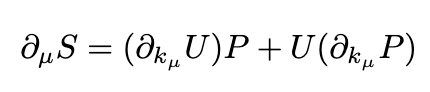

In [ ]:
LHS = dS
RHS = dU @ P + U @ dP

print(np.allclose(LHS, RHS))

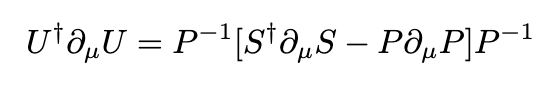

In [ ]:
LHS = U.conj().swapaxes(-1,-2) @ dU
RHS = np.linalg.inv(P) @ (S.conj().swapaxes(-1,-2) @ dS - P @ dP) @ np.linalg.inv(P)

diff = LHS - RHS
print(np.allclose(LHS, RHS))
print(np.amax(diff))

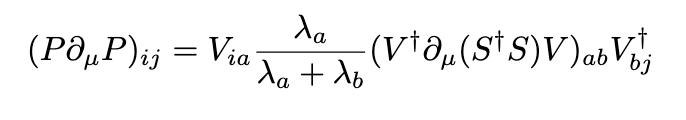

In [ ]:
lambd, V = np.linalg.eig(P)

LHS = P @ dP

mid_mat = V.conj().swapaxes(-1,-2) @ (dS.conj().swapaxes(-1,-2) @ S + S.conj().swapaxes(-1,-2) @ dS) @ V
for a in range(mid_mat.shape[-2]):
    for b in range(mid_mat.shape[-1]):
        mid_mat[:, a, b] *= (lambd[:, a] / (lambd[:, a] + lambd[:, b])) 

RHS = V @ mid_mat @ V.conj().swapaxes(-1,-2)

diff = LHS - RHS
print(np.allclose(LHS, RHS))
print(np.amax(diff))

In [ ]:
lambd, V = np.linalg.eig(P)

LHS = P @ dP

mid_mat = Vh @ (dS.conj().swapaxes(-1,-2) @ S + S.conj().swapaxes(-1,-2) @ dS) @ Vh.conj().swapaxes(-1,-2)
for a in range(mid_mat.shape[-2]):
    for b in range(mid_mat.shape[-1]):
        mid_mat[:, a, b] *= (Sigma[:, a] / (Sigma[:, a] + Sigma[:, b])) 

RHS = Vh.conj().swapaxes(-1,-2) @ mid_mat @ Vh

diff = LHS - RHS
print(np.allclose(LHS, RHS))
print(np.amax(diff))